# Run Segment Anything Model 2 on a live video stream


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display
import time
from sam2.build_sam import build_sam2_camera_predictor


In [3]:
# # use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Building the SAM 2 camera predictor


In [4]:
sam2_checkpoint = "../checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [6]:
cap = cv2.VideoCapture("../webcam_test.mp4")
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

#### Step 1: Add a first click on the first frame


Inference time: 0.019312381744384766


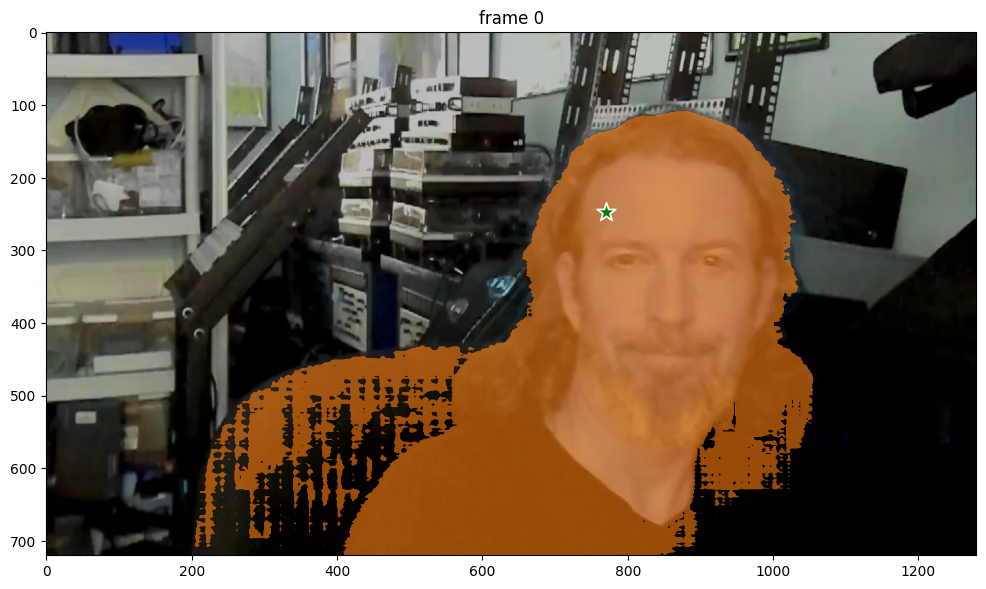

In [14]:
torch.set_float32_matmul_precision('high')
# predictor.load_first_frame(torch.tensor(frame, dtype=torch.float32, device='cuda'))
predictor.load_first_frame(frame)

if_init = True

using_point = True # if True, we use point prompt
using_box = False # if True, we use point prompt
using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[770, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)
bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)

# CUDA stream for efficient operations
stream = torch.cuda.Stream()

with torch.cuda.stream(stream), torch.no_grad(): 
    frame_pil = Image.fromarray(frame)  # Convert numpy array to PIL image
    predictor.load_first_frame(frame_pil)
    start_time = time.time()
    if using_point:
        _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )
        show_points(points, labels, plt.gca())
    
    elif using_box:
        _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
        )
        show_bbox(bbox, plt.gca())
    
    elif using_mask:
        mask_img_path="masks/aquarium/aquarium_mask.png"
        mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
        mask = mask / 255
    
        _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
            frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
        )
        
    print("Inference time:", time.time() - start_time)

show_mask((out_mask_logits[0] > 0.5).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


In [ ]:
vis_gap = 5

while True:

    ret, frame = cap.read()
    ann_frame_idx += 1
    if not ret:
        break
    width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)

    if ann_frame_idx % vis_gap == 0:
        print(f"frame {ann_frame_idx}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(f"frame {ann_frame_idx}")
        plt.imshow(frame)
        show_mask(
            (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
        )

cap.release()

In [30]:
cap.release()

In [16]:
import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Parameters
vis_gap = 0
show_frame = False  # Set to True to display frames, False to display only FPS

# Initialize variables for FPS calculation
fps = 0
frame_count = 0
start_time = time.time()

while True:
    ret, frame = cap.read()
    ann_frame_idx += 1
    if not ret:
        break
    width, height = frame.shape[:2][::-1]

    # Start timer for FPS calculation
    frame_start_time = time.time()

    # Process frame with predictor
    out_obj_ids, out_mask_logits = predictor.track(frame)

    # End timer for FPS calculation
    frame_end_time = time.time()
    frame_time = frame_end_time - frame_start_time

    # Update FPS calculation
    frame_count += 1
    fps = frame_count / (frame_end_time - start_time)

    if ann_frame_idx % vis_gap == 0:
        # Clear previous output and display updated FPS (and optionally frame)
        clear_output(wait=True)
        print(f"Frame {ann_frame_idx}, FPS: {fps:.2f}")

        if show_frame:
            # Display frame if show_frame is True
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 8))
            plt.title(f"Frame {ann_frame_idx}, FPS: {fps:.2f}")
            plt.imshow(frame_rgb)
            show_mask(
                (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
            )
            display(plt.gcf())
            plt.close()

cap.release()


In [15]:

if_init = False
frame_count = 0  # Frame counter for FPS calculation

# Start timing
start_time = time.time()

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame_count += 1  # Increment frame count

        # Only perform initialization on the first frame
        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            obj_id = 1  # Example object ID
            frame_idx = 0

            # Define the point prompt at one-third from the right, centered vertically
            point = [int(width * 2 / 3), int(height / 2)]
            points = [point]
            labels = [1]  # Positive prompt

            # Display the point on the frame as a visual confirmation
            cv2.circle(frame, tuple(point), radius=5, color=(0, 255, 0), thickness=-1)  # Green dot

            # Initialize segmentation with the point prompt
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx, obj_id, points=points, labels=labels)

        else:
            # Track the object in subsequent frames
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask only if it's non-empty
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8") * 255
        else:
            mask = np.zeros((height, width), dtype="uint8")

        # Invert and prepare the mask for overlay
        inverted_mask_colored = cv2.cvtColor(cv2.bitwise_not(mask), cv2.COLOR_GRAY2BGR)
        overlayed_frame = cv2.addWeighted(frame, 0.7, inverted_mask_colored, 0.3, 0)

        # Convert from BGR to RGB for display in Jupyter notebook
        overlayed_frame_rgb = cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        clear_output(wait=True)  # Clear previous output
        plt.imshow(overlayed_frame_rgb)
        plt.axis('off')
        plt.show()

# End timing
end_time = time.time()
cap.release()

# Calculate FPS
total_time = end_time - start_time
fps = frame_count / total_time
print(f"Processed {frame_count} frames in {total_time:.2f} seconds (FPS: {fps:.2f})")


Processed 0 frames in 0.00 seconds (FPS: 0.00)


In [29]:

if_init = False
frame_count = 0  # Frame counter for FPS calculation

# Start timing
start_time = time.time()

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame_count += 1  # Increment frame count

        # Only perform initialization on the first frame
        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            obj_id = 1  # Example object ID
            frame_idx = 0

            # Define the point prompt at one-third from the right, centered vertically
            point = [int(width * 2 / 3), int(height / 2)]
            points = [point]
            labels = [1]  # Positive prompt

            # Initialize segmentation with the point prompt
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx, obj_id, points=points, labels=labels)

        else:
            # Track the object in subsequent frames
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask only if it's non-empty
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8") * 255
        else:
            mask = np.zeros((height, width), dtype="uint8")

        # Invert and prepare the mask for overlay (not displayed)
        inverted_mask_colored = cv2.cvtColor(cv2.bitwise_not(mask), cv2.COLOR_GRAY2BGR)
        overlayed_frame = cv2.addWeighted(frame, 0.7, inverted_mask_colored, 0.3, 0)

# End timing
end_time = time.time()
cap.release()

# Calculate FPS
total_time = end_time - start_time
fps = frame_count / total_time
print(f"Processed {frame_count} frames in {total_time:.2f} seconds (FPS: {fps:.2f})")


Processed 333 frames in 15.20 seconds (FPS: 21.91)


In [17]:
torch.set_float32_matmul_precision('medium')
# Set up constants
ret, frame = cap.read()
height, width = frame.shape[:2]
obj_id = 1  # Example object ID
frame_idx = 0
point = [int(width * 2 / 3), int(height / 2)]  # Precomputed point coordinates
points = [point]
labels = [1]  # Positive prompt

# Frame counter for FPS calculation
frame_count = 0  

# Start timing
start_time = time.time()

# CUDA stream for efficient operations
stream = torch.cuda.Stream()

# Initial frame processing
with torch.cuda.stream(stream):
    predictor.load_first_frame(frame)
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx, obj_id, points=points, labels=labels)

# Process each frame in the video
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while ret:
        frame_count += 1
        if frame_count > 1:  # Skip the first frame setup
            out_obj_ids, out_mask_logits = predictor.track(frame)
        
        # Avoid reallocating the mask array
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8")
        else:
            mask = np.zeros((height, width), dtype="uint8")

        # Prepare the inverted mask and overlay frame (in-place operations)
        inverted_mask = cv2.bitwise_not(mask)
        inverted_mask_colored = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)
        overlayed_frame = cv2.addWeighted(frame, 0.7, inverted_mask_colored, 0.3, 0)

        # Read the next frame
        ret, frame = cap.read()

# End timing and release resources
end_time = time.time()
cap.release()

# Calculate FPS
total_time = end_time - start_time
fps = frame_count / total_time
print(f"Processed {frame_count} frames in {total_time:.2f} seconds (FPS: {fps:.2f})")


AttributeError: 'NoneType' object has no attribute 'shape'

### 